In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from lbg_forecast import emulator as em
from lbg_forecast import population_model as pop

In [2]:
bands = ["u","g","r","i","z"]

loss_bands = []
val_bands = []

for band in bands:
    loss = np.load("trained_models/loss_lsst_"+band+".npy")
    val = np.load("trained_models/valloss_lsst_"+band+".npy")

    loss_bands.append(loss)
    val_bands.append(val)

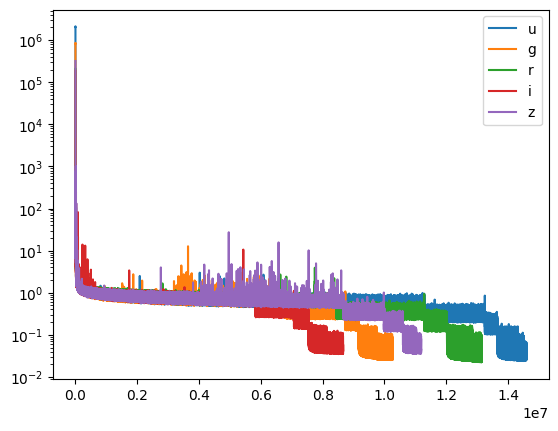

In [3]:
i = 0
for x in loss_bands:
    plt.plot(x, label=bands[i])
    i+=1

plt.yscale("log")
plt.legend()

0.028039980679750443
0.028271446004509926
0.027161289006471634
0.04382093995809555
0.045324184000492096


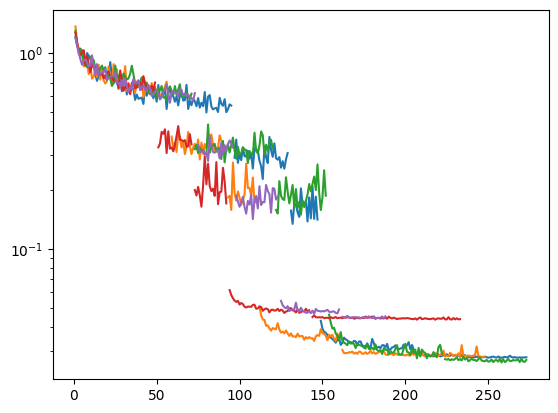

In [4]:
i = 0
for y in val_bands:
    plt.plot(y)
    print(y[-1])

plt.yscale("log")

In [5]:
model = em.fsps_emulator("/Users/fpetri/repos/LBGforecast")

In [6]:
sps_params_train = np.load("validation_data/sps_parameters_1200000.npy")
phot_train = np.load("validation_data/photometry_1200000.npy")


/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/speculator/speculator.py:709: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])


(3.631e-36, 5.754747181826305e-27)

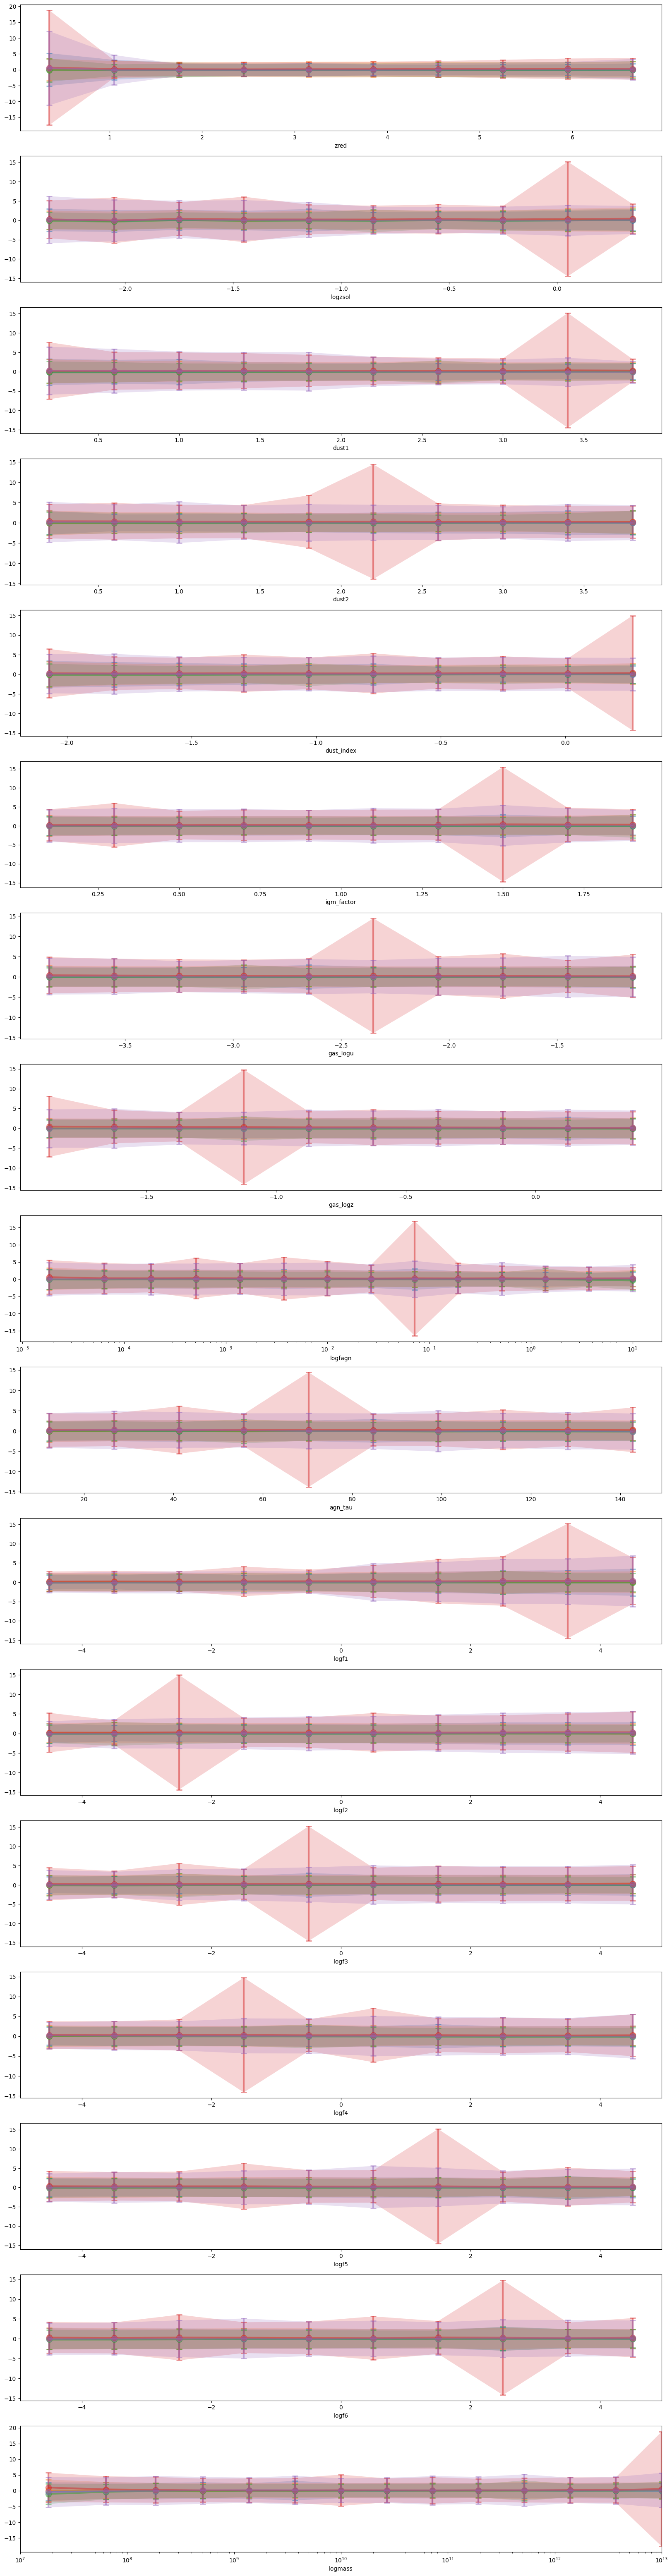

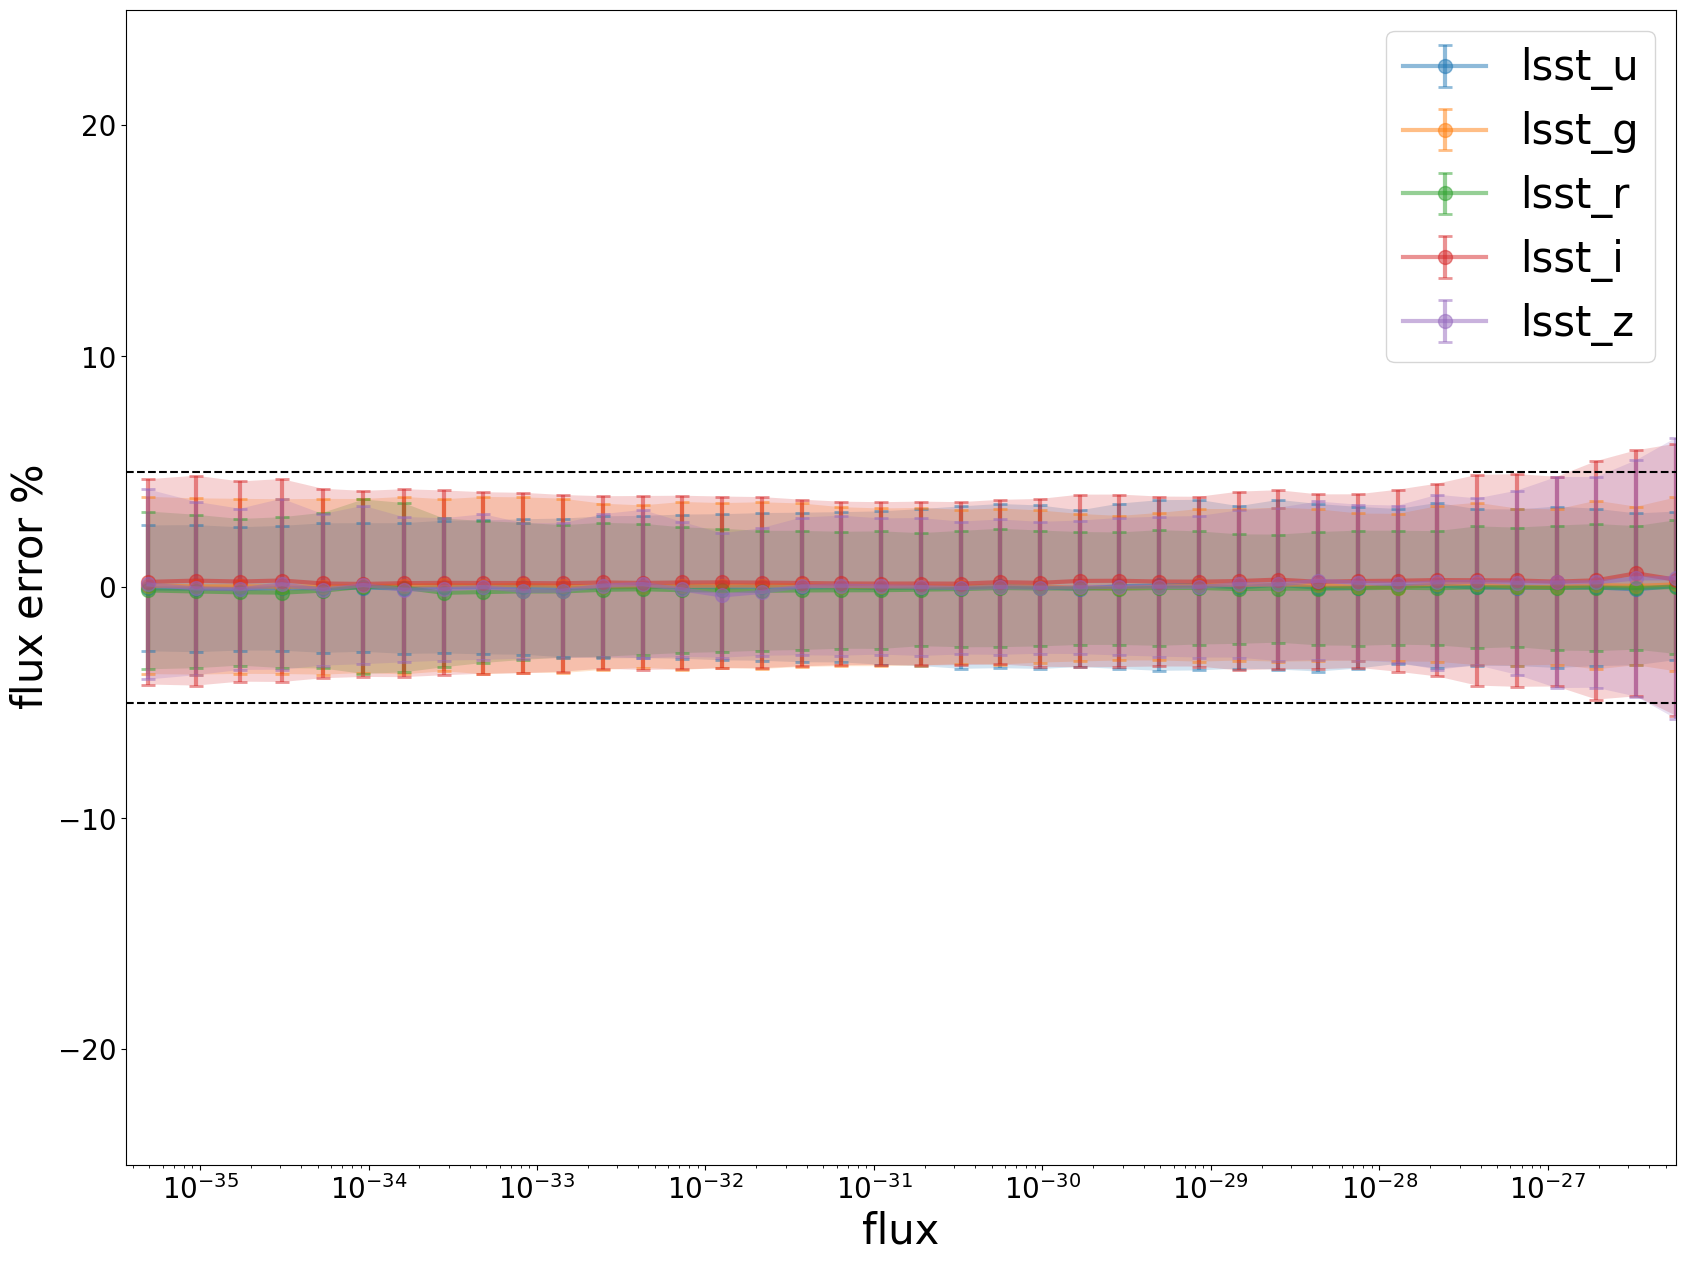

In [7]:
def mab_to_flux(mag):
    return 3.631e-20*10**(-(mag/2.5))

def quantile(data):
    return np.quantile(data, 0.95)

def get_outliers(flux_err, threshold):
    inds = np.where(abs(flux_err) > threshold)[0]
    return inds

min_flux = mab_to_flux(40)
max_flux = mab_to_flux(17)


nsamples=1000000
y_bound = 5.0
batch_size = 1000

sps_params = sps_params_train[:nsamples, :]
flux_mimic = mab_to_flux(model.mimic_photometry(sps_params[:,], batch_size=batch_size))
flux_true = mab_to_flux(phot_train[:nsamples, :-1])

nbands = 5
bands = ["u","g","r","i","z"]

fig1, axes = plt.subplots(sps_params.shape[1], 1, figsize=(20,80), sharex=False, sharey=False)
alpha = 0.5
for i in range(sps_params.shape[1]):
    for j in range(nbands):
        flux_err = ((flux_mimic[:, j]-flux_true[:, j])/(flux_true[:, j]))*100
        

        if(pop.sps_parameter_names()[i] == "logmass" or pop.sps_parameter_names()[i] == "logfagn"):
            axes[i].set_xscale('log')

        axes[i].set_xlabel(pop.sps_parameter_names()[i])
        if(pop.sps_parameter_names()[i] == "logmass" or pop.sps_parameter_names()[i] == "logfagn"):
            bin_means, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], flux_err[:,],'mean', bins=np.logspace(np.log10(np.min(sps_params[:, i])), np.log10(np.max(sps_params[:, i])), 15))
            bin_std, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], flux_err[:,],'std', bins=np.logspace(np.log10(np.min(sps_params[:, i])), np.log10(np.max(sps_params[:, i])), 15))
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2
        else:
            bin_means, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], flux_err[:,],'mean')
            bin_std, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], flux_err[:,],'std')
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2

        axes[i].errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=20, marker=".", elinewidth=3, capsize=5, capthick=2, lw=3)
        axes[i].fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2)

        if(pop.sps_parameter_names()[i] == "logmass"):
            axes[i].set_xlim(1e7, 1e13)




fig2, axes2 = plt.subplots(1, 1, figsize=(20,15), sharex=False, sharey=False)

for j in range(nbands):
    flux_err = ((flux_mimic[:, j]-flux_true[:, j])/(flux_true[:, j]))*100

    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(flux_true[:, j], flux_err[:,],'mean', np.logspace(np.log10(min_flux), np.log10(max_flux), 40))
    bin_std, bin_edges, binnumber = sc.stats.binned_statistic(flux_true[:, j], flux_err[:,],quantile, np.logspace(np.log10(min_flux), np.log10(max_flux), 40))
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    axes2.errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=20, marker=".", elinewidth=3, capsize=5, capthick=2, lw=3, label='lsst_'+bands[j])
    axes2.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2)

    inds = get_outliers(flux_err, y_bound)

    #axes2.scatter(flux_true[inds, np.ones_like(inds)*j], flux_err[inds], s=10.0, alpha=1.0, label='lsst_'+bands[j])



axes2.set_xlabel('flux', fontsize=30)
axes2.set_ylabel('flux error $\%$', fontsize=30)
axes2.set_xscale('log')
axes2.tick_params(axis='both', which='major', labelsize=20)
axes2.tick_params(axis='both', which='minor', labelsize=20)
axes2.legend(fontsize=30)

axes2.axhline(y=y_bound, color='k', linestyle='--')
axes2.axhline(y=-y_bound, color='k', linestyle='--')

#axes2.axhline(y=y_bound/2, color='k', linestyle='-')
#axes2.axhline(y=-y_bound/2, color='k', linestyle='-')

axes2.set_ylim(-25, 25)

axes2.set_xlim(min_flux, max_flux)


In [8]:
sps_params_train = np.load("validation_data/sps_parameters_1200000.npy")
phot_train = np.load("validation_data/photometry_1200000.npy")

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/speculator/speculator.py:709: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])


total outliers:  3.08
total outliers:  5.66
total outliers:  4.64
total outliers:  7.22
total outliers:  5.76


(-1.5, 1.5)

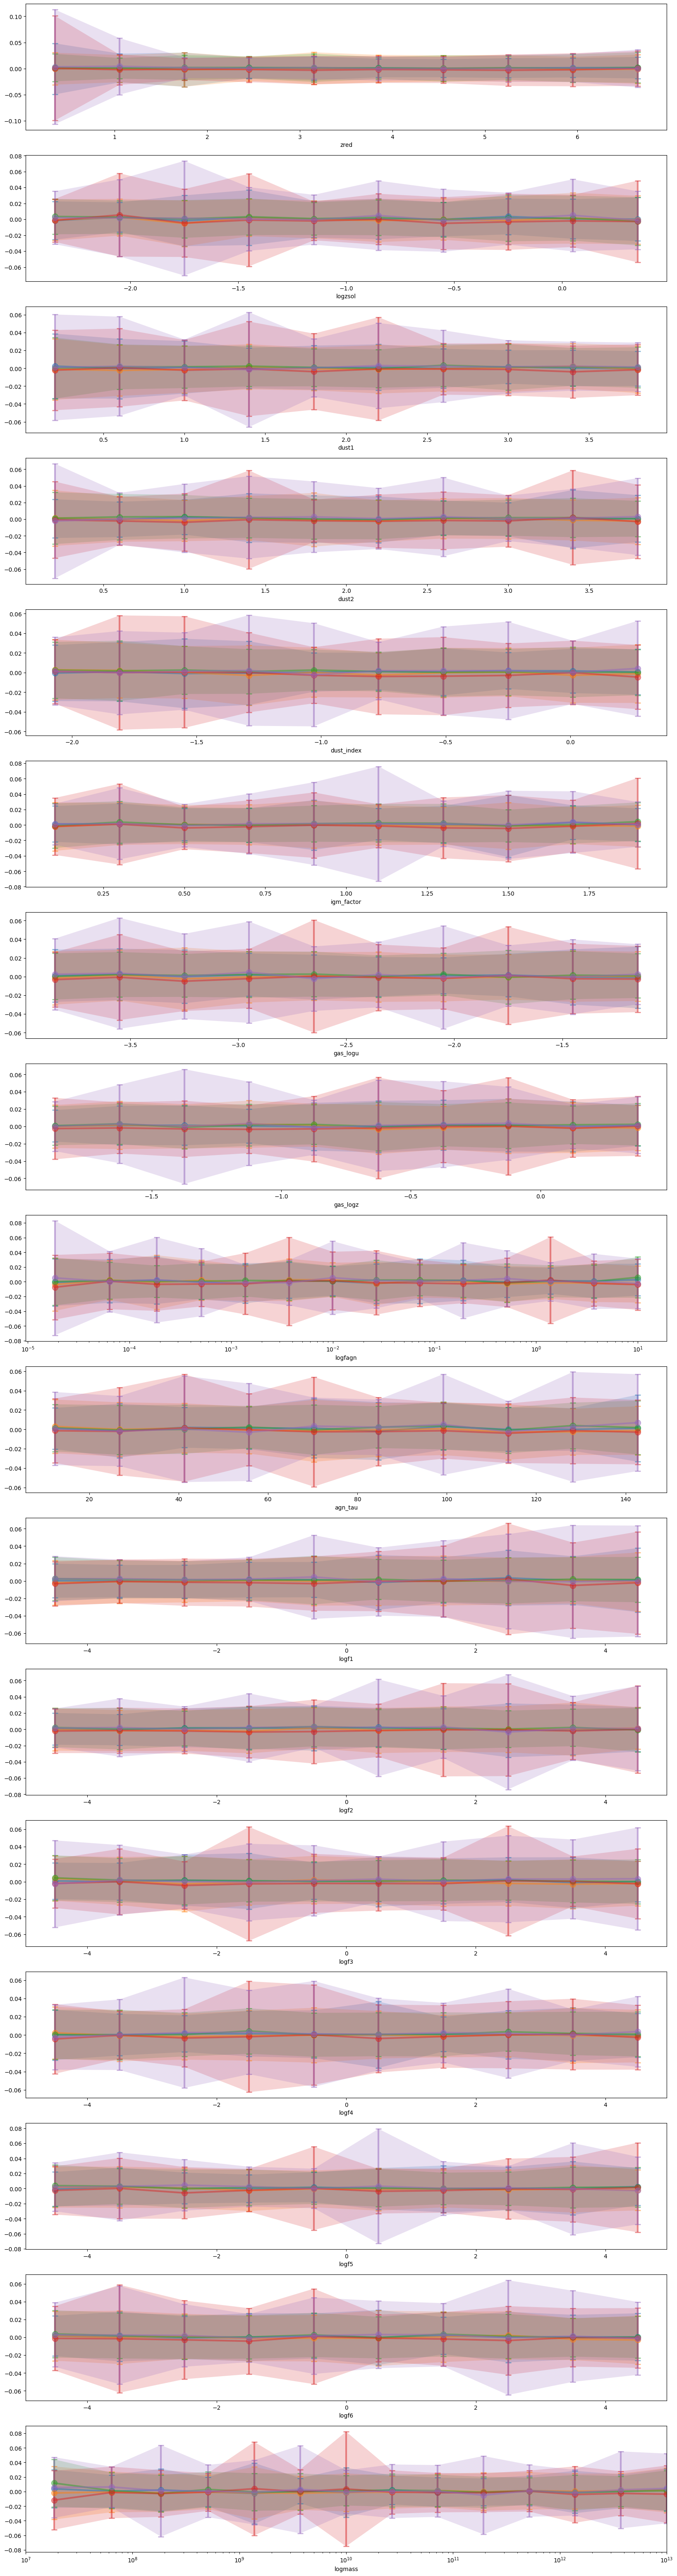

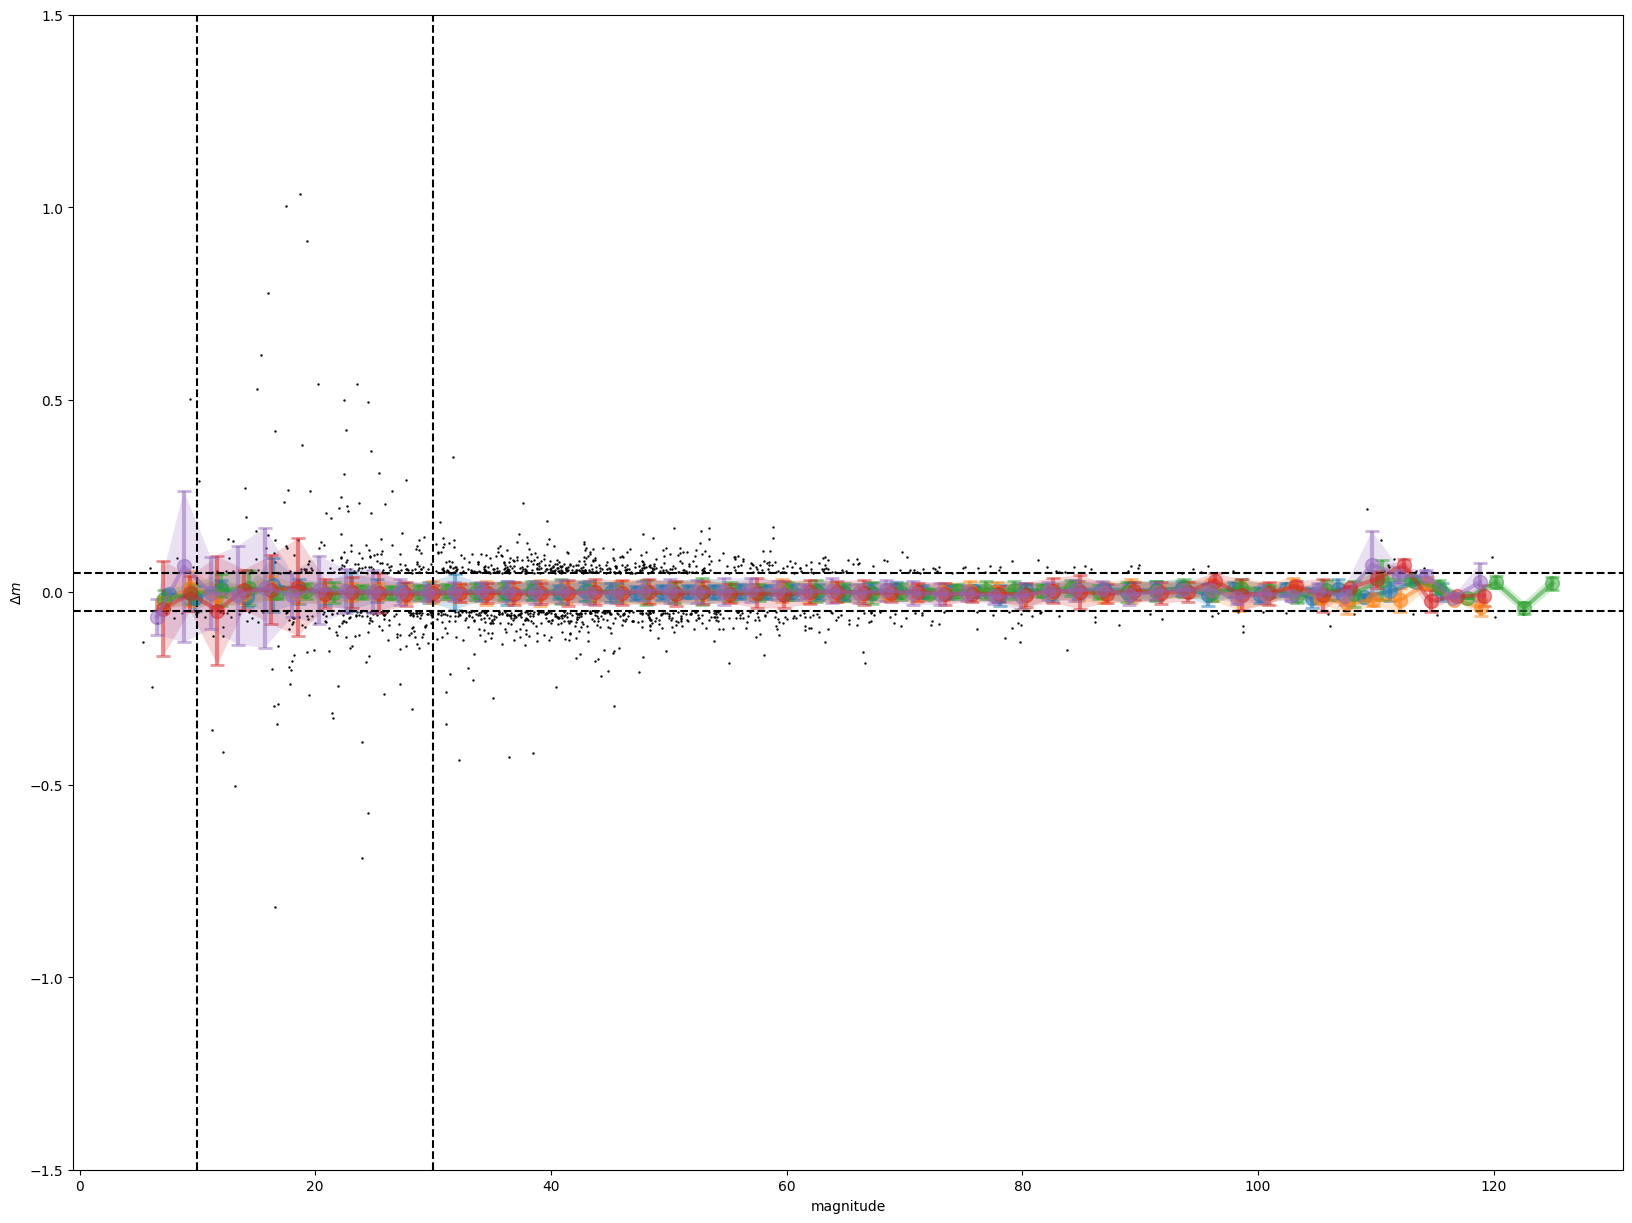

In [9]:
nsamples=5000
y_bound = 0.05
sps_params = sps_params_train[:nsamples, :]
m_mimic = model.mimic_photometry(sps_params[:,], batch_size=1000)
m_true = phot_train[:nsamples, :-1]
nbands = 5 

fig1, axes = plt.subplots(sps_params.shape[1], 1, figsize=(20,80), sharex=False, sharey=False)
alpha = 0.5
for i in range(sps_params.shape[1]):
    for j in range(nbands):
        dm = m_mimic[:, j]-m_true[:, j]
        #axes[i].scatter(sps_params[:, i], dm[:,], alpha=alpha)
        

        if(pop.sps_parameter_names()[i] == "logmass" or pop.sps_parameter_names()[i] == "logfagn"):
            axes[i].set_xscale('log')

        axes[i].set_xlabel(pop.sps_parameter_names()[i])
        if(pop.sps_parameter_names()[i] == "logmass" or pop.sps_parameter_names()[i] == "logfagn"):
            bin_means, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'mean', bins=np.logspace(np.log10(np.min(sps_params[:, i])), np.log10(np.max(sps_params[:, i])), 15))
            bin_std, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'std', bins=np.logspace(np.log10(np.min(sps_params[:, i])), np.log10(np.max(sps_params[:, i])), 15))
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2
        else:
            bin_means, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'mean')
            bin_std, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'std')
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2

        axes[i].errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=20, marker=".", elinewidth=3, capsize=5, capthick=2, lw=3)
        axes[i].fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2)

        if(pop.sps_parameter_names()[i] == "logmass"):
            axes[i].set_xlim(1e7, 1e13)



fig2, axes2 = plt.subplots(1, 1, figsize=(20,15), sharex=False, sharey=False)

for j in range(nbands):
    dm = m_mimic[:, j]-m_true[:, j]
    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(m_true[:, j], dm[:,],'mean', 50)
    bin_std, bin_edges, binnumber = sc.stats.binned_statistic(m_true[:, j], dm[:,],'std', 50)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    axes2.errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=20, marker=".", elinewidth=3, capsize=5, capthick=2, lw=3)
    axes2.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2)

    inds = np.where(abs(dm) > y_bound)[0]
    dm_outliers = dm[inds]
    m_true_outliers = m_true[inds, np.ones_like(inds)*j]

    axes2.scatter(m_true[inds, np.ones_like(inds)*j], dm[inds], s=0.5, c='k')
    print("total outliers: ", (len(dm_outliers)/len(dm))*100)



axes2.set_xlabel('magnitude')
axes2.set_ylabel('$\Delta m$')

axes2.axhline(y=y_bound, color='k', linestyle='--')
axes2.axhline(y=-y_bound, color='k', linestyle='--')

#axes2.axhline(y=0.1, color='k', linestyle='-')
#axes2.axhline(y=0.1, color='k', linestyle='-')

axes2.axvline(x=10, color='k', linestyle='--')
axes2.axvline(x=30, color='k', linestyle='--')

axes2.set_ylim(-1.5, 1.5)

#axes2.set_xlim(0, 40)


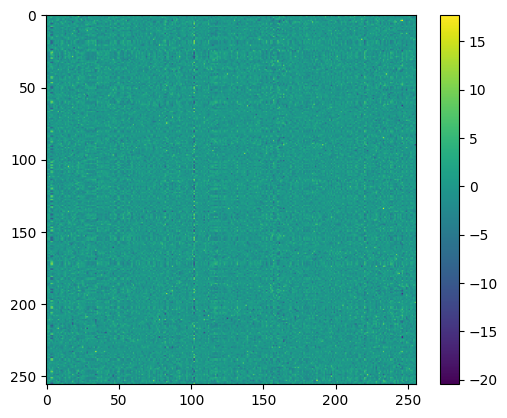

In [10]:
weights = model._models[0].W
biases = model._models[0].b
a = model._models[0].alphas
b = model._models[0].betas

layer = 5

weights[layer].shape

plt.imshow(np.transpose(weights[layer]))
plt.colorbar()

(array([ 3.,  2.,  2.,  9., 40., 47., 68., 43., 19.,  7.,  5.,  3.,  1.,
         3.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([-0.14264159, -0.11821597, -0.09379035, -0.06936473, -0.04493912,
        -0.0205135 ,  0.00391211,  0.02833773,  0.05276335,  0.07718897,
         0.10161458,  0.12604021,  0.15046582,  0.17489143,  0.19931705,
         0.22374266,  0.24816829,  0.27259392,  0.29701951,  0.32144514,
         0.34587076,  0.37029636,  0.39472198,  0.41914761,  0.44357324,
         0.46799883,  0.49242446,  0.51685005,  0.54127568,  0.56570131,
         0.59012693,  0.61455256,  0.63897818,  0.66340375,  0.68782938,
         0.712255  ,  0.73668063,  0.76110625,  0.78553188,  0.8099575 ,
         0.83438307,  0.8588087 ,  0.88323432,  0.90765995,  0.93208557,
         0.9565112 ,  0.98093683,  1.00536239,  1.02978802,

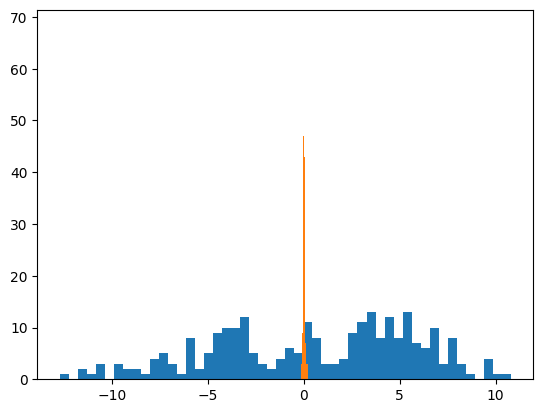

In [11]:
layer = 5

plt.hist(a[layer].numpy(), bins=50)
plt.hist(b[layer].numpy(), bins=50)

#plt.hist(a[layer])

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0., 11., 11.,
        12.,  8.,  4.,  4.,  4.,  6.,  3.,  9.,  7.,  6.,  6.,  4.,  5.,
         5., 18.,  5.,  8.,  5.,  2.,  5., 13.,  4.,  2.,  3.,  5.,  3.,
         9.,  5.,  5.,  8.,  6.,  8.,  3.,  8., 11., 10.,  2.]),
 array([-20.34446144, -19.66547585, -18.98649025, -18.30750465,
        -17.62851906, -16.94953346, -16.27054787, -15.59156322,
        -14.91257763, -14.23359203, -13.55460644, -12.87562084,
        -12.19663525, -11.5176506 , -10.83866501, -10.15967941,
         -9.48069382,  -8.80170822,  -8.12272263,  -7.44373751,
         -6.76475191,  -6.08576632,  -5.40678072,  -4.7277956 ,
         -4.04881001,  -3.36982441,  -2.69083881,  -2.01185346,
         -1.33286798,  -0.6538825 ,   0.025103  ,   0.70408845,
          1.38307393,   2.0620594 ,   2.741045  ,   3.42003036,
          4.09901571,   4.77800131,   5.4569869 ,   6.1359725 ,
          6.81495762,   7.49394321,   8.17292881,   8.85191441,
          9.

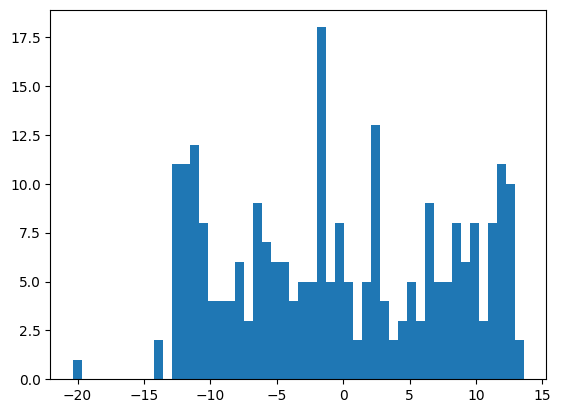

In [12]:
layer = 5

biases[layer].shape
plt.hist(biases[layer].numpy(), bins=50)